In [1]:
# extracting the HOG features from images
from skimage import feature
def quantify_image(image):
    features = feature.hog(image, orientations=9,
                           pixels_per_cell=(10, 10), cells_per_block=(2, 2),
                           transform_sqrt=True, block_norm="L1")
    return features

In [2]:
# Processing the dataset, i.e., converting the images into features and labels
import cv2
from imutils import paths
import numpy as np
import os
def process_dataset(path):
  imagePaths = list(paths.list_images(path))  #path = path of the dataset 
  data = []
  labels = []
  for imagePath in imagePaths: #iterating through each image eg. imagePath = /content/spiral/testing/parkinson/V07PE01.png
    # print(imagePath)
    label = imagePath.split(os.path.sep)[-2] #getting label of each image, i.e., parkinson or healthy
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image, (200, 200))
    image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    features = quantify_image(image)  #extracting features of image
    data.append(features) 
    labels.append(label)
  return (np.array(data), np.array(labels)) #returning the feature array and the corresponding label array

In [3]:
#spiliting the dataset into testing and training and returning the feature and labels array for testing and training
from sklearn.preprocessing import LabelEncoder
# from sklearn.preprocessing import StandardScaler     
import os
def select_and_split_dataset(data_set):
  path = './drawings/'+data_set   #defining the path for this google colab, must be changed accordingly for different platforms
  trainingPath = os.path.sep.join([path, "training"])
  testingPath = os.path.sep.join([path, "testing"])
  # load the data
  trainX, trainY = process_dataset(trainingPath)
  testX, testY = process_dataset(testingPath)
  # st_x= StandardScaler()  
  # trainX= st_x.fit_transform(trainX)    
  # testX= st_x.transform(testX)  
  le = LabelEncoder() # LabelEncoder encodes the label arrays into binary (Parkinsons = 1, Healthy = 0)
  trainY = le.fit_transform(trainY)
  testY = le.transform(testY)
  return trainX, trainY, testX, testY

In [4]:
#testing the model with the test data
#returns the predicted values and prints the confusion matrix and accuracy score for different models
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
def test(model, testX, testY):
  predY = model.predict(testX)
  cm = confusion_matrix(testY, predY)
  print('confusion matrix = ',cm)
  accuracy = accuracy_score(testY, predY)
  print('accuracy score = ',accuracy)
  return predY

In [5]:
import pickle
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

In [6]:
#dictionary to pre-define different models to shorten the code
models={
    'RF': RandomForestClassifier(random_state=10),
    'XGBoost': XGBClassifier(),
    'SVM': LinearSVC(C=1, random_state=1),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'DecisionTree': DecisionTreeClassifier(random_state=10)
}

In [7]:
#dictionary to store the predictions of spiral model
prediction_spiral = {
    'RF' : [],
    'XGBoost' : [],
    'SVM' : [],
    'KNN' : [],
    'DecisionTree' : []
}

In [8]:
#dictionary to store the predictions of wave model
prediction_wave = {
    'RF' : [],
    'XGBoost' : [],
    'SVM' : [],
    'KNN' : [],
    'DecisionTree' : []
}

In [9]:
#getting and splitting both the datasets
spiral = 'spiral'
strainX, strainY, stestX, stestY = select_and_split_dataset(spiral)
wave = 'wave'
wtrainX, wtrainY, wtestX, wtestY = select_and_split_dataset(wave)

In [10]:
#to train the models
def train_model(model, trainX, trainY):
  model.fit(trainX, trainY)
  return model

In [11]:
#iterating through the models dictionary and training each model for spiral dataset
for model in models:
  model_spiral = train_model(models[model], strainX, strainY)
  pickle.dump(model_spiral, open('spiral_'+model+'_model.pickel', 'wb'))    #saving the model as a pickle file with name 'spiral_{model_name}_model.pickel'
#iterating through the models dictionary and training each model for wave dataset
for model in models:
  model_wave = train_model(models[model], wtrainX, wtrainY)
  pickle.dump(model_wave, open('wave_'+model+'_model.pickel', 'wb'))    #saving the model as a pickle file  with name 'wave_{model_name}_model.pickel'

In [12]:
#printing the confusion matrix and accuracy of different models for spiral dataset
#and storing the predicted array in prediction_spiral dictionary
for model in models:
  print('model = ',model)
  prediction_spiral[model] = test(pickle.load(open('spiral_'+model+'_model.pickel', 'rb')), stestX, stestY)
  print('-----------------------')  

model =  RF
confusion matrix =  [[13  2]
 [ 4 11]]
accuracy score =  0.8
-----------------------
model =  XGBoost
confusion matrix =  [[11  4]
 [ 4 11]]
accuracy score =  0.7333333333333333
-----------------------
model =  SVM
confusion matrix =  [[11  4]
 [ 4 11]]
accuracy score =  0.7333333333333333
-----------------------
model =  KNN
confusion matrix =  [[11  4]
 [ 2 13]]
accuracy score =  0.8
-----------------------
model =  DecisionTree
confusion matrix =  [[11  4]
 [ 4 11]]
accuracy score =  0.7333333333333333
-----------------------


In [13]:
#printing the confusion matrix and accuracy of different models for wave dataset
#and storing the predicted array in prediction_wave dictionary 
for model in models:
  print('model = ',model)
  prediction_wave[model] = test(pickle.load(open('wave_'+model+'_model.pickel', 'rb')), wtestX, wtestY)
  print('-----------------------') 

model =  RF
confusion matrix =  [[ 9  6]
 [ 5 10]]
accuracy score =  0.6333333333333333
-----------------------
model =  XGBoost
confusion matrix =  [[10  5]
 [ 4 11]]
accuracy score =  0.7
-----------------------
model =  SVM
confusion matrix =  [[12  3]
 [ 5 10]]
accuracy score =  0.7333333333333333
-----------------------
model =  KNN
confusion matrix =  [[10  5]
 [ 2 13]]
accuracy score =  0.7666666666666667
-----------------------
model =  DecisionTree
confusion matrix =  [[9 6]
 [6 9]]
accuracy score =  0.6
-----------------------


In [14]:
#displaying the output predicted by the random forest model on the test images
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
def display_output_img(dataset, preds, testY):
    path = './drawings/'+dataset+'/testing'
    imagePaths = list(paths.list_images(path))  #getting the images in the same way as process_dataset method
    output = [] #array to store the images with text on them
    for i, images in enumerate(imagePaths): #enumerate to simplify comparing the predicted output with the actual output
        image = cv2.imread(images)
        font = cv2.FONT_HERSHEY_COMPLEX_SMALL
        color = (0, 255, 0) if preds[i] == testY[i] else (255, 0, 0)  #red for false output, green for true
        stroke = 2
        text = 'Parkinsons' if preds[i] else 'Healthy'  #preds array is in form [1, 1, 0, 0, 0, .....] where ) = healthy, 1 = parkinsons
        # print(image)
        cv2.putText(image, text, (20, 20), font, 1, color, stroke, cv2.LINE_AA)
        output.append(image)  #appending the images with text to output array
    for i in range(len(output)):
        plt.subplot(6, 5, i+1)  #6, 5 is used since there are 30 test images, needs to be changed accordingly
        plt.imshow(output[i])
        plt.axis('off')

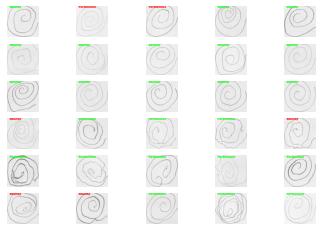

In [15]:
display_output_img('spiral', prediction_spiral['RF'], stestY)

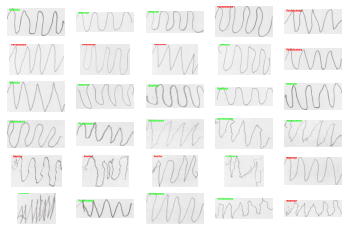

In [16]:
display_output_img('wave', prediction_wave['RF'], wtestY)